# Fine Tuning XLNET for identification of Human Values behind Arguments

### Introduction

In this notebook we will be fine tuning XLNET model
for the **detection of human values** given a specifc argument. It consists of a **Multilabel text classification** problem where a given piece of text needs to be classified into one or more categories out of the given list. For example, as in this case, a given argument can be categorized into 1 or more human values.

At the time of its publication on 19 June 2019, XLNet achieved state-of-the-art results on 18 tasks including text classification, question-answering, natural language inference, sentiment analysis, and document ranking. It even outperformed BERT on 20 tasks! Developed by Carnegie Mellon University and Google Brain, XLNet is a permutation-based auto-regressive language model.

We will be using the Transformers library developed by HuggingFace. The Transformers library provides easy to use implementations of numerous state-of-the-art language models : BERT, XLNet, GPT-2, RoBERTa, CTRL, etc.

#### Flow of the notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing the domain data](#section02)
3. [Preparing train and validation split and Dataloader](#section03)
4. [Defining the train function](#section04)
5. [Building of the XLNet classification model](#section05)
6. [Fine Tuning the Model](#section06)
7. [Evaluating the best model](#section07)
8. [Choosing the best threshold](#section08)
9. [Results](#section09)

#### Technical Details

 - Data: 
	 - We are using the data available on [Zenodo](https://zenodo.org/record/7550385#.Y8wMquzMK3I)
     - [Human Value Detection 2023](https://touche.webis.de/semeval23/touche23-web/index.html) is the competion which provide the souce dataset
	 - We are referring only to the following data: `arguments-training.tsv`, `arguments-validation`, `labels-training.tsv`, `labels-validation.tsv`
	 
     - `arguments-<split>.tsv`: Each row corresponds to one argument
        - `Argument ID`: The unique identifier for the argument
        - `Conclusion`: Conclusion text of the argument
        - `Stance`: Stance of the Premise towards the Conclusion; one of "in favor of", "against"
        - `Premise`: Premise text of the argument

     - `labels-<split>.tsv`: Each row corresponds to one argument
        - `Argument ID`: The unique identifier for the argument
        - `Other`: Each other column corresponds to one value category, with a 1 meaning that the argument resorts to the value category and a 0 that not
---
***NOTE***
- *Since test data are provided without labels, we did not consider them for our analysis. In this regards **the performances of our models have been tested only on validation data**.*
---
  
 - Language Model Used:
   - XLNET BASE
   - XLENT LARGE

 - Hardware Requirements:
	 - Python 3.6 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup 

 - Script Objective:
	 - Fine tuning of XLNET model such that: given a textual argument, classify whether or not the argument draws on one of the following categories:
        * Self-direction: thought      
        * Self-direction: action       
        * Stimulation     
        * Hedonism       
        * Achievement      
        * Power: dominance       
        * Power: resources       
        * Face       
        * Security: personal      
        * Security: societal      
        * Tradition       
        * Conformity: rules       
        * Conformity: interpersonal       
        * Humility       
        * Benevolence: caring       
        * Benevolence: dependability      
        * Universalism: concern       
        * Universalism: nature       
        * Universalism: tolerance      
        * Universalism: objectivity       

---
***NOTE***
- *It is to be noted that the overall mechanisms for a multiclass and multilabel problems are similar, except for few differences namely:*
	- *Loss function is designed to evaluate all the probability of categories individually rather than as compared to other categories. Hence the use of `BCE` rather than `Cross Entropy` when defining loss.*
	- *Sigmoid of the outputs calcuated to rather than Softmax. Again for the reasons defined in the previous point*
	- *The [accuracy metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) and [F1 scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) used from sklearn package as compared to direct comparison of expected vs predicted*
---

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Numpy
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* XLNetTokenizer and XLNetModel

Followed by that we will preapre the device for GPU execeution. This configuration is needed if you want to leverage on onboard GPU.

RANDOM SEED has been set to 42 to ensure experiments reproducibility.

In [1]:
# Installing the transformers library and additional libraries if looking process 

!pip install -q transformers
!pip install SentencePiece
!pip install mlcm

# Code for TPU packages install
# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import math

import torch
import transformers
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Random seed to repeat experiments.
RANDOM_SEED = 42
transformers.set_seed(RANDOM_SEED)

In [8]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Using {device}.')

Using cuda.


<a id='section02'></a>
### Importing the domain data

We will be working with the data and preparing for fine tuning purposes. 
*Assuming that the `train.csv` is already downloaded, unzipped and saved in your `data` folder*

* Import the file in a dataframe and give it the headers as per the documentation.
* Taking the values of all the categories and coverting it into a list.
* The list is appened as a new column and other columns are removed

In [ ]:
args_train = pd.read_csv("arguments-training.tsv", delimiter='\t')
labels_train = pd.read_csv("labels-training.tsv", delimiter='\t')

We now prepare our training DataFrame. The choice of concatenation of conclusion, stance and premise attempts to enhance the process of applying attention, in order to perform better at capturing relationships between words using transformers.

In [ ]:
df = args_train.merge(labels_train)
df['text'] = df.Conclusion + ' ' + df.Stance +' '+ df.Premise
train = df[df.columns[4:]].copy()
train.head()

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,...,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity,text
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,We should ban human cloning in favor of we sho...
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,We should ban fast food in favor of fast food ...
2,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,We should end the use of economic sanctions ag...
3,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,We should abolish capital punishment against c...
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,We should ban factory farming against factory ...


In [ ]:
args_test = pd.read_csv("arguments-validation.tsv", delimiter='\t')
labels_test = pd.read_csv("labels-validation.tsv", delimiter='\t')

Preparation of test set:

In [ ]:
df = args_test.merge(labels_test)
df['text'] = df.Conclusion + ' ' + df.Stance +' '+ df.Premise
test = df[df.columns[4:]].copy()
test.head()

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,...,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity,text
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Entrapment should be legalized in favor of if ...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,The use of public defenders should be mandator...
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,Payday loans should be banned in favor of payd...
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Surrogacy should be banned against Surrogacy s...
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,Entrapment should be legalized against entrapm...


<a id='section03'></a>
### Preparing train and validation split

#### Choosing the model

We train and test five different pretrained models. Here we select the model and specify the hyperparameters.

In [ ]:
#MODEL_NAME = 'xlnet-base-cased'
MODEL_NAME = 'xlnet-large-cased'
is_large_model = "large" in MODEL_NAME

OUT_CHANNELS = 1024 if is_large_model else 768
print("Model selected:", MODEL_NAME, "\nOut channels:", OUT_CHANNELS)

Model selected: xlnet-large-cased 
Out channels: 1024


#### Distribution of sentences length

We plot a distribution over the lengths of the sequences. This will help us choose the truncation length.

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

In [ ]:
train_text_list = train["text"].values

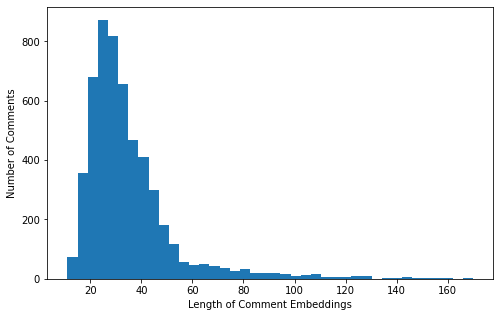

In [ ]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

In [ ]:
test_text_list = test["text"].values

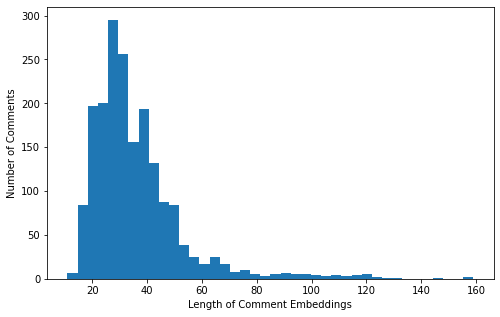

In [ ]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

#### Inputs tokenization and creation of attention mask
We need to preprocess our data in order to correctly create train and validation split to perform our task. The preocessing stage involves two phases:
1. **Tokenization of the inputs**: convert the input text sequence into the appropriate numeric token ids.
2. **Creation of the attention mask**: instruct the model on the appropriate tokens to perform attention on. The objective is to prevent our model from performing attention on padding tokens.

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=100):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=100)
train_input_ids

array([[  80,  170, 2440, ...,    0,    0,    0],
       [  80,  170, 2440, ...,    0,    0,    0],
       [  80,  170,  239, ...,    0,    0,    0],
       ...,
       [ 626,  795,  845, ...,    0,    0,    0],
       [ 626,  795,  845, ...,    0,    0,    0],
       [  18,   17, 4269, ...,    0,    0,    0]])

In [ ]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=100)
test_input_ids

array([[   17,   254, 21737, ...,     0,     0,     0],
       [   18,   164,    20, ...,     0,     0,     0],
       [ 8226,  1728,   170, ...,     0,     0,     0],
       ...,
       [   80,   170,   829, ...,     0,     0,     0],
       [   80,   170,  5742, ...,     0,     0,     0],
       [   80,   170,  5742, ...,    27,     4,     3]])

In [ ]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
print(train_attention_masks)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [ ]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)
print(test_attention_masks)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [ ]:
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

In [ ]:
train.head()

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,...,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity,text,features,masks
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,We should ban human cloning in favor of we sho...,"[80, 170, 2440, 594, 25366, 25, 3313, 20, 80, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,We should ban fast food in favor of fast food ...,"[80, 170, 2440, 1365, 626, 25, 3313, 20, 1365,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,We should end the use of economic sanctions ag...,"[80, 170, 239, 18, 164, 20, 531, 3811, 157, 13...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,We should abolish capital punishment against c...,"[80, 170, 22428, 688, 6532, 157, 688, 6532, 27...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,0,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,We should ban factory farming against factory ...,"[80, 170, 2440, 4435, 9153, 157, 4435, 9153, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
# add input ids and attention masks to the dataframe
test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [ ]:
test.head()

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,...,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity,text,features,masks
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,Entrapment should be legalized in favor of if ...,"[17, 254, 21737, 889, 170, 39, 1054, 1227, 25,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,The use of public defenders should be mandator...,"[18, 164, 20, 281, 15449, 170, 39, 10563, 25, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,Payday loans should be banned in favor of payd...,"[8226, 1728, 170, 39, 4803, 25, 3313, 20, 8226...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Surrogacy should be banned against Surrogacy s...,"[17, 4146, 17453, 6412, 170, 39, 4803, 157, 17...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,Entrapment should be legalized against entrapm...,"[17, 254, 21737, 889, 170, 39, 1054, 1227, 157...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


#### Train and validation split
We will use our testing set to validate the model

In [ ]:
valid = test

In [ ]:
train.columns[:20]

Index(['Self-direction: thought', 'Self-direction: action', 'Stimulation',
       'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources',
       'Face', 'Security: personal', 'Security: societal', 'Tradition',
       'Conformity: rules', 'Conformity: interpersonal', 'Humility',
       'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity'],
      dtype='object')

In [ ]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

label_cols = train.columns[:20]
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

#### Create dataloaders
- Convert all of our input ids and attention masks into torch tensors, the required datatype for our model
- Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory

In [ ]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

<ipython-input-107-ebb8a01c48c2>:7: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  train_masks = torch.tensor(train_masks, dtype=torch.long)
<ipython-input-107-ebb8a01c48c2>:8: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  valid_masks = torch.tensor(valid_masks, dtype=torch.long)


In [ ]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

<a id='section04'></a>
### Train function
We will now define the training function. During training, the function will save the model whenever it achieves the lowest validation loss.

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("\nTrain loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0
    
    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}\n".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    #print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs+1,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

<a id='section05'></a>
### XLNet classification model
Since the input sequence has 100 tokens, XLNet will produce 100 output vectors, with each vector having either a dimension of 768 (XLNET base) or 1024 (XLNET large). We will perform a mean-pooling of the output vectors and produce a single vector with a dimension of 768/1024. This vector will be the input to the fully-connected layer that will predict the 20 human values categories.


<center>
<img src="https://miro.medium.com/max/4800/1*9NYGAL5tgxf1GkvE_GEhYg.webp" width="300" />
</center>


There are other ways to pool the output, such as concatenating the outputs into a single large vector, or even using the outputs from the last few hidden layers of XLNet.



In [ ]:
torch.cuda.empty_cache()

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained(MODEL_NAME)
    self.classifier = torch.nn.Linear(OUT_CHANNELS, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model.freeze_xlnet_decoder()
#model = torch.nn.DataParallel(model)
#model.cuda()

In [ ]:
model.xlnet.layer[-3:]

ModuleList(
  (0): XLNetLayer(
    (rel_attn): XLNetRelativeAttention(
      (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (ff): XLNetFeedForward(
      (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (layer_1): Linear(in_features=1024, out_features=4096, bias=True)
      (layer_2): Linear(in_features=4096, out_features=1024, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation_function): GELUActivation()
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (1): XLNetLayer(
    (rel_attn): XLNetRelativeAttention(
      (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (ff): XLNetFeedForward(
      (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (layer_1): Linear(in_features=1024, out_features=4096, bias=True)
      (layer_2): Linear(in_features=4096, ou

### Reinitializing Last 3 Layers (Only for XLNET large)
Because of the small size of the dataset, XLNET large model shows very high overfitting and its performances are much worse than the XLNET base architecture. According to the following [tutorial](https://www.kaggle.com/code/rhtsingh/on-stability-of-few-sample-transformer-fine-tuning) available on Kaggle, this issue may be solved by **re-Initializing transformer layers**

This is a very interesting technique where instead of using the pretrained weights for all layers, we re-initialize the pooler layers and the top Transformer blocks using the original Transformer initialization. The layers reinitialized results in destruction of gained pretrained knowledge for those specific blocks.

The idea is motivated by computer vision transfer learning results where we know that lower pre-trained layers learn more general features while higher layers closer to the output specialize more to the pre-training tasks. Existing methods using Transformer show that using the complete network is not always the most effective choice and usually slows down training and hurts performance.

We "pool" the model by simply taking the hidden state corresponding to the first token.

We opted for the re-inizialization of the last 3 Layers of the model, by using the code provided by the aforementioned tutorial.


In [ ]:
from transformers import logging
from transformers.models.xlnet.modeling_xlnet import XLNetRelativeAttention
logging.set_verbosity_warning()
logging.set_verbosity_error()
reinit_layers = 3

if is_large_model and reinit_layers > 0:
    print(f'Reinitializing Last {reinit_layers} Layers ...')
    for layer in model.xlnet.layer[-reinit_layers :]:
        for module in layer.modules():
            if isinstance(module, (torch.nn.Linear, torch.nn.Embedding)):
                module.weight.data.normal_(mean=0.0, std=model.xlnet.config.initializer_range)
                if isinstance(module, torch.nn.Linear) and module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, torch.nn.LayerNorm):
                module.bias.data.zero_()
                module.weight.data.fill_(1.0)
            elif isinstance(module, XLNetRelativeAttention):
                for param in [
                    module.q,
                    module.k,
                    module.v,
                    module.o,
                    module.r,
                    module.r_r_bias,
                    module.r_s_bias,
                    module.r_w_bias,
                    module.seg_embed,
                ]:
                    param.data.normal_(mean=0.0, std=model.xlnet.config.initializer_range)
    print('Done.!')

Reinitializing Last 3 Layers ...
Done.!


In [ ]:
model

XLNetForMultiLabelSequenceClassification(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 1024)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=1024, out_features=4096, bias=True)
          (layer_2): Linear(in_features=4096, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetF

### Optimizer

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<a id='section06'></a>
### Training phase

In [ ]:
num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "xlnet.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]


Train loss: 0.021975625720135516
Valid loss: 0.02040612142737405



Epoch:  33%|███▎      | 1/3 [07:44<15:28, 464.33s/it]

Saving model at epoch 1 with validation loss of 0.02040612142737405

Train loss: 0.017374384340783693
Valid loss: 0.019883782260968715



Epoch:  67%|██████▋   | 2/3 [15:47<07:55, 475.35s/it]

Saving model at epoch 2 with validation loss of 0.019883782260968715

Train loss: 0.01438501681431357


Epoch: 100%|██████████| 3/3 [23:43<00:00, 474.42s/it]

Valid loss: 0.02165841883370645



Our model overfits the training set by a margin. We can see the detail of the history of the losses in the graph below.

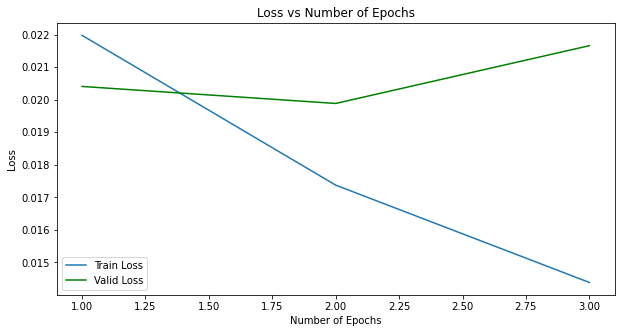

In [ ]:
# Plot loss
num_epochs = np.arange(1,len(train_loss_set)+1)

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")
ax.legend()

<a id='section07'></a>
### Evaluation of the best model

In [ ]:
best_weights_XLNET_base = 'drive/MyDrive/Pesi_NLP/xlnet.bin'
best_weights_XLNET_large = 'drive/MyDrive/Pesi_NLP/xlnet-large.bin'

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
if not is_large_model:
    model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(best_weights_XLNET_base)
    pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=16)

<ipython-input-45-986738fbaa7e>:14: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.tensor(masks, dtype=torch.long)


<a id='section08'></a>
### Choosing the best threshold

Since the outoput scores are probabilities values in the range [0,1] we need to define the best threshold to approximate each score either to 0 or to 1. 
To do that, we considered all possible threshold values between 0.1 and 0.85 with steps of 0.05 such that: all the values higher than or equal to the threshold are approximated to 1, otherwise to 0.
Finally, we take the threshold value which gave us the highest F1 score.

In [ ]:
if not is_large_model:
    results = {}
    df_prediction = test.drop(columns = test.columns[:20])
    for tr in np.arange(0.1, 0.9, 0.05):
        tr = round(tr, 2)
        for i, label in enumerate(label_cols):
            prediction = np.where(pred_probs[:,i] >= tr, 1, 0)
            df_prediction[label] = prediction

        y_pred = df_prediction[df_prediction.columns[3:]].values.tolist()
        y_test = test[test.columns[:-3]].values.tolist()
        f1 = f1_score(y_test, y_pred, average = "macro", zero_division = 1)
        results[tr] = f1
        
    for k,v in results.items():
        print("THRESHOLD: {:.2f} ".format(k), "F1 score: {:.3f}".format(v))

THRESHOLD: 0.10  F1 score: 0.428
THRESHOLD: 0.15  F1 score: 0.438
THRESHOLD: 0.20  F1 score: 0.430
THRESHOLD: 0.25  F1 score: 0.418
THRESHOLD: 0.30  F1 score: 0.401
THRESHOLD: 0.35  F1 score: 0.386
THRESHOLD: 0.40  F1 score: 0.371
THRESHOLD: 0.45  F1 score: 0.356
THRESHOLD: 0.50  F1 score: 0.341
THRESHOLD: 0.55  F1 score: 0.325
THRESHOLD: 0.60  F1 score: 0.303
THRESHOLD: 0.65  F1 score: 0.279
THRESHOLD: 0.70  F1 score: 0.255
THRESHOLD: 0.75  F1 score: 0.230
THRESHOLD: 0.80  F1 score: 0.200
THRESHOLD: 0.85  F1 score: 0.166


In [ ]:
if not is_large_model:
    THRESHOLD = max(results, key = results.get)
    print("BEST THRESHOLD:", THRESHOLD , "with F1 score: {:.2f}".format(max(results.values())))

BEST THRESHOLD: 0.15 with F1 score: 0.44


<a id='section09'></a>
### Classification report

In [ ]:
if not is_large_model:
    df_prediction = test.drop(columns = test.columns[:20])

    for i, label in enumerate(label_cols):
        prediction = np.where(pred_probs[:,i] >= THRESHOLD, 1, 0)
        df_prediction[label] = prediction

    y_pred = df_prediction[df_prediction.columns[3:]].values.tolist()
    y_test = test[test.columns[:-3]].values.tolist()

    print(classification_report(y_test,y_pred, target_names = label_cols))

                            precision    recall  f1-score   support

   Self-direction: thought       0.34      0.75      0.46       251
    Self-direction: action       0.43      0.78      0.56       496
               Stimulation       0.50      0.13      0.21       138
                  Hedonism       0.53      0.40      0.46       103
               Achievement       0.54      0.83      0.65       575
          Power: dominance       0.26      0.48      0.34       164
          Power: resources       0.36      0.79      0.50       132
                      Face       0.26      0.08      0.13       130
        Security: personal       0.48      0.97      0.64       759
        Security: societal       0.36      0.93      0.52       488
                 Tradition       0.42      0.48      0.45       172
         Conformity: rules       0.39      0.80      0.52       455
 Conformity: interpersonal       0.20      0.23      0.22        60
                  Humility       0.18      0.17

## XLNET LARGE

In [ ]:
num_labels = len(label_cols)
if is_large_model:
    model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(best_weights_XLNET_large)
    pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=16)

<ipython-input-45-986738fbaa7e>:14: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.tensor(masks, dtype=torch.long)


In [ ]:
if is_large_model:
    results = {}
    df_prediction = test.drop(columns = test.columns[:20])
    for tr in np.arange(0.1, 0.9, 0.05):
        tr = round(tr, 2)
        for i, label in enumerate(label_cols):
            prediction = np.where(pred_probs[:,i] >= tr, 1, 0)
            df_prediction[label] = prediction

        y_pred = df_prediction[df_prediction.columns[3:]].values.tolist()
        y_test = test[test.columns[:-3]].values.tolist()
        f1 = f1_score(y_test, y_pred, average = "macro", zero_division = 1)
        results[tr] = f1
        
    for k,v in results.items():
        print("THRESHOLD: {:.2f} ".format(k), "F1 score: {:.3f}".format(v))

THRESHOLD: 0.10  F1 score: 0.461
THRESHOLD: 0.15  F1 score: 0.485
THRESHOLD: 0.20  F1 score: 0.496
THRESHOLD: 0.25  F1 score: 0.491
THRESHOLD: 0.30  F1 score: 0.483
THRESHOLD: 0.35  F1 score: 0.474
THRESHOLD: 0.40  F1 score: 0.460
THRESHOLD: 0.45  F1 score: 0.448
THRESHOLD: 0.50  F1 score: 0.433
THRESHOLD: 0.55  F1 score: 0.412
THRESHOLD: 0.60  F1 score: 0.393
THRESHOLD: 0.65  F1 score: 0.366
THRESHOLD: 0.70  F1 score: 0.339
THRESHOLD: 0.75  F1 score: 0.307
THRESHOLD: 0.80  F1 score: 0.275
THRESHOLD: 0.85  F1 score: 0.237


In [ ]:
if is_large_model:
    THRESHOLD = max(results, key = results.get)
    print("BEST THRESHOLD:", THRESHOLD , "with F1 score: {:.2f}".format(max(results.values())))

BEST THRESHOLD: 0.2 with F1 score: 0.50


In [ ]:
if is_large_model:
    df_prediction = test.drop(columns = test.columns[:20])

    for i, label in enumerate(label_cols):
        prediction = np.where(pred_probs[:,i] >= THRESHOLD, 1, 0)
        df_prediction[label] = prediction

    y_pred = df_prediction[df_prediction.columns[3:]].values.tolist()
    y_test = test[test.columns[:-3]].values.tolist()

    print(classification_report(y_test,y_pred, target_names = label_cols))

                            precision    recall  f1-score   support

   Self-direction: thought       0.43      0.62      0.51       251
    Self-direction: action       0.49      0.80      0.61       496
               Stimulation       0.34      0.41      0.37       138
                  Hedonism       0.57      0.50      0.53       103
               Achievement       0.59      0.73      0.65       575
          Power: dominance       0.28      0.46      0.35       164
          Power: resources       0.48      0.48      0.48       132
                      Face       0.31      0.34      0.33       130
        Security: personal       0.66      0.86      0.75       759
        Security: societal       0.53      0.78      0.63       488
                 Tradition       0.52      0.50      0.51       172
         Conformity: rules       0.52      0.73      0.61       455
 Conformity: interpersonal       0.45      0.15      0.23        60
                  Humility       0.26      0.17

# Error Analysis

As a premise for the error analysis, we first want to make sure that our choice for tokenizer model max length is reasonable. Here we calculate the percentile where we find our choice:

In [ ]:
from scipy.stats import percentileofscore

lens = []
for s in test['text']:
  lens.append(len(s.split(' ')))

percentile_of = percentileofscore(lens, 100)
print(percentile_of)

99.84177215189874


Having roughly 99% of our sentences shorter than 100 words, we believe 100 to be a reasonable max tokenizer length.

We choose to carry out error analysis on roberta-large. This is the model that performed better compared to the other bert/roberta models. Specifically, we want to know which classes have been confused with other classes and how frequently. To do this, we are going to use a Multi Label Confusion Matrix, rendered with seaborn's heatmap.

MLCM has one extra row (NTL) and one extra column (NPL).        
Please read the following paper for more information:
        Heydarian et al., MLCM: Multi-Label Confusion Matrix, IEEE Access,2022        
To skip this message, please add parameter "print_note=False"
        e.g., conf_mat,normal_conf_mat = mlcm.cm(label_true,label_pred,False)


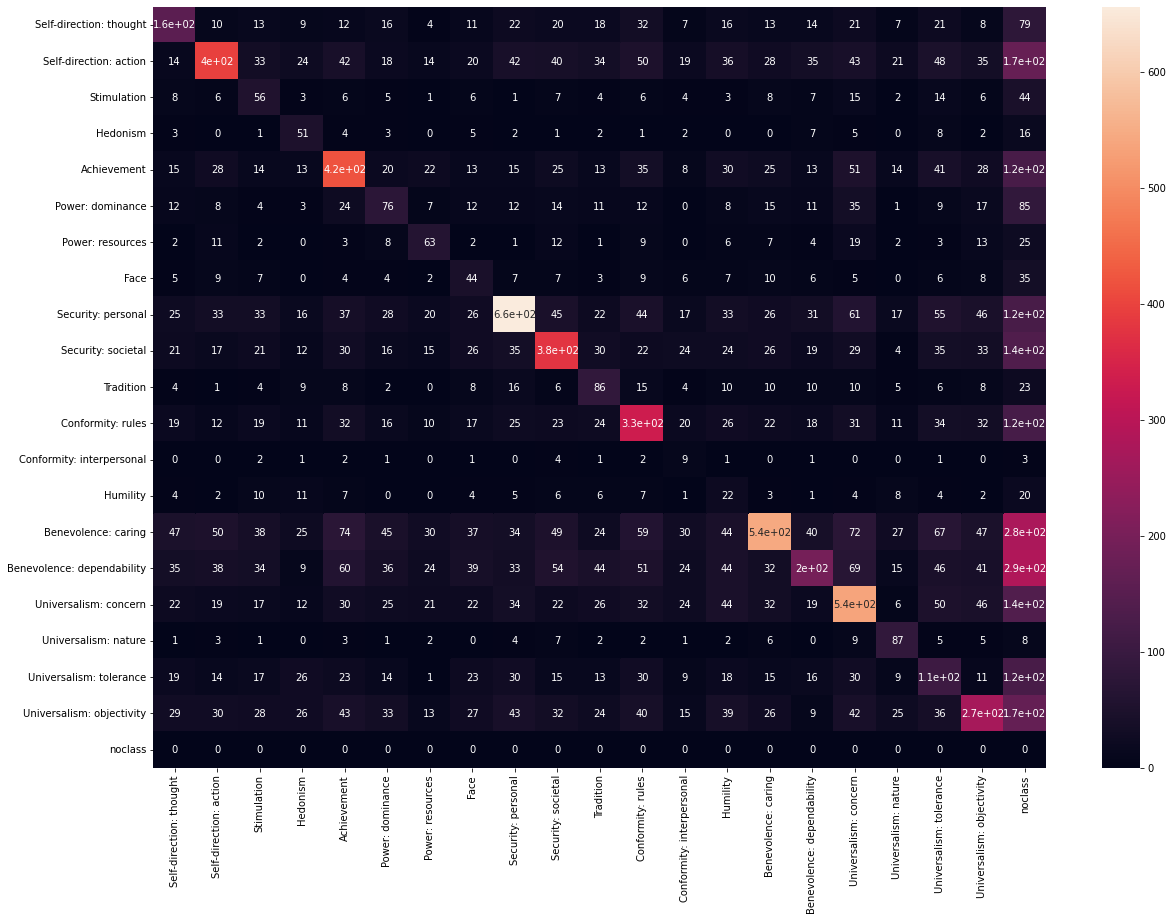

In [ ]:
from mlcm import mlcm
import seaborn as sn
import matplotlib.pyplot as plt

conf_mat,normal_conf_mat = mlcm.cm(y_pred,y_test)
df_cm = pd.DataFrame(conf_mat, index = [i for i in label_cols.append(pd.Index(['noclass']))],
                  columns = [i for i in label_cols.append(pd.Index(['noclass']))])
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True)